# Explore composition of correlated genes

This notebook explores deeper into the genes that are found based on their correlation score.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pickle
import scipy as sc

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(123)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Input
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
local_dir = "/home/alexandra/Documents/"

base_intermediate_dir = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "tmp")

real_expression_all_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "input",
    "selected_All_data.tsv")

real_expression_pao1_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "input",
    "selected_PAO1_data.tsv")

real_expression_pa14_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "input",
    "selected_PA14_data.tsv")

core_gene_ids_file = os.path.join(
    base_intermediate_dir,
    "core_gene_ids.pickle")

acc_gene_ids_file = os.path.join(
    base_intermediate_dir,
    "acc_gene_ids.pickle")

In [3]:
# Read expression data
real_expression_all = pd.read_csv(
    real_expression_all_file,
    header=0,
    sep='\t',
    index_col=0)

real_expression_pao1 = pd.read_csv(
    real_expression_pao1_file,
    header=0,
    sep='\t',
    index_col=0)

real_expression_pa14 = pd.read_csv(
    real_expression_pa14_file,
    header=0,
    sep='\t',
    index_col=0)

In [4]:
# Read in gene ids
core_gene_ids = pickle.load(open(core_gene_ids_file, "rb"))
acc_gene_ids = pickle.load(open(acc_gene_ids_file, "rb"))

In [5]:
# Get core-core gene expression
real_core_expression_all = real_expression_all[core_gene_ids]
real_core_expression_pao1 = real_expression_pao1[core_gene_ids]
real_core_expression_pa14 = real_expression_pa14[core_gene_ids]

In [6]:
# Get accessory-accessory gene expression
real_acc_expression_all = real_expression_all[acc_gene_ids]
real_acc_expression_pao1 = real_expression_pao1[acc_gene_ids]
real_acc_expression_pa14 = real_expression_pa14[acc_gene_ids]

## Evolution of PAO1 and PA14

Whole-genome phylogenetic analysis found two major groups (PAO1, PA14) using the core genome
The PA14 and PAO1 clonal complexes have diverged evolutionary based on SNPs that were present in most isolates of one group and absent in all isolates of the other

References:
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6690169/
* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7197496/
* https://www.pnas.org/content/pnas/105/8/3100.full.pdf

**Question:** Since PA14 and PAO1 have diverged, what accessory genes from PAO1 are shared with PA14 strains as they evolve and adapt?

In [7]:
# Get correlation of accessory-accessory genes
real_acc_corr_pao1 = real_acc_expression_pao1.corr(method='pearson')
real_acc_corr_pa14 = real_acc_expression_pa14.corr(method='pearson')

In [8]:
# Reshape correlation data
real_acc_corr_pao1 = real_acc_corr_pao1.where(np.triu(np.ones(real_acc_corr_pao1.shape), k=1).astype(np.bool))
real_acc_corr_pao1 = real_acc_corr_pao1.stack().reset_index()
real_acc_corr_pao1.columns = ['in gene','out gene','corr score']

real_acc_corr_pa14 = real_acc_corr_pa14.where(np.triu(np.ones(real_acc_corr_pa14.shape), k=1).astype(np.bool))
real_acc_corr_pa14 = real_acc_corr_pa14.stack().reset_index()
real_acc_corr_pa14.columns = ['in gene','out gene','corr score']

print(real_acc_corr_pao1.shape)
print(real_acc_corr_pa14.shape)

(20100, 3)
(20100, 3)


In [9]:
# Get only highly correlated relationships
highly_acc_corr_pao1 = real_acc_corr_pao1[real_acc_corr_pao1['corr score']>0.5]
highly_acc_corr_pa14 = real_acc_corr_pa14[real_acc_corr_pa14['corr score']>0.5]

print(highly_acc_corr_pao1.shape)
print(highly_acc_corr_pa14.shape)
highly_acc_corr_pao1.head()

(6880, 3)
(9293, 3)


,in gene,out gene,corr score
0,PA0053,PA0095,0.892283
1,PA0053,PA0100,0.771820
11,PA0053,PA0257,0.873920
12,PA0053,PA0258,0.938533
13,PA0053,PA0445,0.670422


In [10]:
highly_acc_corr_pa14.head()

,in gene,out gene,corr score
4,PA0053,PA0188,0.604890
5,PA0053,PA0202,0.758231
6,PA0053,PA0203,0.694165
7,PA0053,PA0204,0.721027
8,PA0053,PA0205,0.582750


In [11]:
# Get genes that are highly correlated in PAO1
highly_acc_genes_pao1 = np.unique(np.concatenate([highly_acc_corr_pao1['in gene'].values,
                                                  highly_acc_corr_pao1['out gene'].values]
                                                )
                                 )

print(len(highly_acc_genes_pao1))

199


In [12]:
# Get genes that are highly correlated in PA14
highly_acc_genes_pa14 = np.unique(np.concatenate([highly_acc_corr_pa14['in gene'].values,
                                                  highly_acc_corr_pa14['out gene'].values]
                                                )
                                 )

print(len(highly_acc_genes_pa14))

201


In [13]:
shared_acc_genes = set(highly_acc_genes_pao1).intersection(set(highly_acc_genes_pa14))
pao1_acc_genes = set(highly_acc_genes_pao1).difference(set(highly_acc_genes_pa14))
pa14_acc_genes = set(highly_acc_genes_pa14).difference(set(highly_acc_genes_pao1))

print("Accessory genes highly correlated with other accessory genes in PAO1 and PA14: ", len(shared_acc_genes))
print("Accessory genes highly correlated with other accessory genes in PAO1 only: ", len(pao1_acc_genes))
print("Accessory genes highly correlated with other accessory genes in PA14 only: ", len(pa14_acc_genes))

Accessory genes highly correlated with other accessory genes in PAO1 and PA14:  199
Accessory genes highly correlated with other accessory genes in PAO1 only:  0
Accessory genes highly correlated with other accessory genes in PA14 only:  2


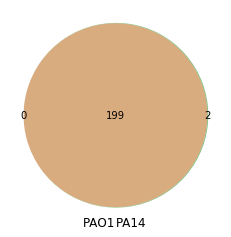

In [14]:
venn2([set(highly_acc_genes_pao1), set(highly_acc_genes_pa14)],
      set_labels = ('PAO1', 'PA14'),
      set_colors=('red', 'green'),
      alpha=0.5
     )
plt.show()

Recall our definition of core and accessory genes. **core gene** = genes that are homologous between PAO1 and PA14; **accessory gene** in this case are PAO1-specific genes (since the array we are using is using the PAO1 reference genome).

**Observations:**
* 199 accessory genes that are highly connected with other accessory genes in both PAO1 and PA14 background
* 2 accessory genes that are highly connected with other accessory genes in only PA14 strains background -- niche genes?
* Highly correlated accessory genes are conserved across strains

What are these "accessory genes in both PAO1 and PA14"? 
* Say gene X is an accessory gene, meaning gene X is PAO1-specific and not present in PA14. There can still be some cross hybridization with the array such that we can detect some level of expression for gene X in PA14 samples.  
* Then, say accessory gene X is highly correlated with accessory gene Y using PAO1 only samples. Accessory gene X is also highly correlated with some other accessory gene Z using PA14 samples. So gene X is higher correlated in both PAO1 and PA14
* So it’s not that gene X is actually present in both strains PAO1 and PA14, it’s just that gene X is present in the array so there will be some expression because of cross-hybridization that can lead gene X being highly correlated with other genes.

## Accessory relationships with core or other accessory genes

**Definition:** 
Accessory genes can be strain-specific, so they are unique genes or they can be partially conserved, so shared with some strains but not all, call these flexible genes

[Jiao et. al.](https://pubmed.ncbi.nlm.nih.gov/29795552), who found that more conserved genes (like flexible genes) in S. fredii (Sinorhizobium fredii) were more strongly connected in the co-expression network. This intuition is that as Pseudomonas adapts, newly acquired accessory genes will be integrated into the existing/core regulatory network of the recipient strain. In other words we would expect flexible and core genes to be co-expressed compared to unique and core genes. 

**Question:** Are accessory genes more highly correlated with core genes vs accessory genes? Are the genes that are highly correlated with accessory genes strain-specific?

In [15]:
real_corr_pao1 = real_expression_pao1.corr(method='pearson')

In [16]:
# Get correlation of core-accessory genes
real_core_acc_corr_pao1 = real_corr_pao1.loc[core_gene_ids, acc_gene_ids]

In [17]:
# Reshape correlation data
real_core_acc_corr_pao1 = real_core_acc_corr_pao1.where(
    np.triu(
        np.ones(real_core_acc_corr_pao1.shape), k=1).astype(np.bool))
real_core_acc_corr_pao1 = real_core_acc_corr_pao1.stack().reset_index()
real_core_acc_corr_pao1.columns = ['in gene','out gene','corr score']

In [18]:
# Get only highly correlated relationships
highly_core_acc_corr_pao1 = real_core_acc_corr_pao1[real_core_acc_corr_pao1['corr score']<-0.5]

print(highly_core_acc_corr_pao1.shape)
highly_core_acc_corr_pao1.head()

(4341, 3)


,in gene,out gene,corr score
0,PA0001,PA0095,-0.795914
1,PA0001,PA0100,-0.906186
2,PA0001,PA0135,-0.830546
8,PA0001,PA0205,-0.515965
11,PA0001,PA0257,-0.905672


In [19]:
# Get genes that are highly correlated in PAO1
highly_core_acc_genes_pao1 = np.unique(np.concatenate([highly_core_acc_corr_pao1['in gene'].values,
                                                       highly_core_acc_corr_pao1['out gene'].values]
                                                )
                                 )

print(len(highly_core_acc_genes_pao1))

377


In [20]:
# Get only accessory genes from core-acc relationships
highly_core_Acc_genes_pao1 = set(highly_core_acc_genes_pao1).intersection(acc_gene_ids)

In [21]:
# Create df components
acc_gene_ids = []
correlated_gene_ids = []
corr_score = []

for acc_gene in highly_core_Acc_genes_pao1:
    rows_found = highly_core_acc_corr_pao1[(highly_core_acc_corr_pao1['in gene'] == acc_gene) | 
                          (highly_core_acc_corr_pao1['out gene'] == acc_gene)
                         ]
    if acc_gene in rows_found['in gene'].values:
        col = 'in gene'
        correlated_col = 'out gene'
    else:
        col = 'out gene'
        correlated_col = 'in gene'
        
    acc_gene_ids.extend(rows_found[col].values)
    correlated_gene_ids.extend(rows_found[correlated_col].values)
    corr_score.extend(rows_found['corr score'].values)

In [22]:
# Initialize df
df = pd.DataFrame(data = {'Accessory gene name': acc_gene_ids,
                          'Correlated gene name': correlated_gene_ids,
                          'Correlation score': corr_score,
    
})
df.tail()

,Accessory gene name,Correlated gene name,Correlation score
4336,PA1150,PA0018,-0.767842
4337,PA1150,PA0019,-0.922655
4338,PA1150,PA0021,-0.740205
4339,PA1150,PA0024,-0.506168
4340,PA1150,PA0031,-0.678294


In [23]:
# Get paired relationship
relationship = []
for index, row in df.iterrows():
    correlated_gene = row['Correlated gene name']
    if correlated_gene in acc_gene_ids:
        relationship.append('acc-acc')
    else:
        relationship.append('acc-core')

In [24]:
df['Relationship'] = relationship
df.head()

,Accessory gene name,Correlated gene name,Correlation score,Relationship
0,PA3701,PA0008,-0.857459,acc-core
1,PA3701,PA0022,-0.654642,acc-core
2,PA3701,PA0023,-0.891241,acc-core
3,PA3701,PA0025,-0.654275,acc-core
4,PA3701,PA0026,-0.610651,acc-core


In [25]:
# Replace gene ids with gene names when available
# Gene number to gene name file
gene_name_file = os.path.join(
    base_dir,
    "pilot_experiment",
    "data",
    "annotations",
    "Pseudomonas_aeruginosa_PAO1_107.csv")

gene_name_mapping = pd.read_csv(
    gene_name_file,
    header=0,
    sep=',',
    index_col=0)

In [26]:
# Format gene id
gene_name_mapping = gene_name_mapping[["Locus Tag", "Name"]]

gene_name_mapping.set_index("Locus Tag", inplace=True)
gene_name_mapping.index = gene_name_mapping.index.str.strip("\"")
gene_name_mapping.head()

,Name
Locus Tag,
PA0001,dnaA
PA0002,dnaN
PA0003,recF
PA0004,gyrB
PA0005,lptA


In [27]:
# Create dictionary to use for mapping
gene_name_mapping_dict = gene_name_mapping.T.to_dict('index')
gene_name_mapping_dict = gene_name_mapping_dict['Name']

This table contains the following columns:
1. All accessory genes that are highly correlated with either a core or accessory gene
2. What gene that accessory gene is correlated with
3. What the correlation score is
4. If the relationship is accessory-core or accessory-accessory

In [28]:
# Replace gene ids with gene names
df['Accessory gene name'] = df['Accessory gene name'].map(gene_name_mapping_dict).fillna(df['Accessory gene name'])
df['Correlated gene name'] = df['Correlated gene name'].map(gene_name_mapping_dict).fillna(df['Correlated gene name'])
df.head()

,Accessory gene name,Correlated gene name,Correlation score,Relationship
0,peptide chain release factor 2(prfB),glyS,-0.857459,acc-core
1,peptide chain release factor 2(prfB),PA0022,-0.654642,acc-core
2,peptide chain release factor 2(prfB),qor,-0.891241,acc-core
3,peptide chain release factor 2(prfB),aroE,-0.654275,acc-core
4,peptide chain release factor 2(prfB),plcB,-0.610651,acc-core


In [29]:
df.tail()

,Accessory gene name,Correlated gene name,Correlation score,Relationship
4336,pys2,fmt,-0.767842,acc-core
4337,pys2,def,-0.922655,acc-core
4338,pys2,PA0021,-0.740205,acc-core
4339,pys2,hemF,-0.506168,acc-core
4340,pys2,betC,-0.678294,acc-core


In [30]:
# Save
output_file = os.path.join(
    local_dir,
    "Data",
    "Core_accessory",
    "highly_corr_accessory_genes.csv")

df.to_csv(output_file, sep='\t', index=False)

In [31]:
# Get counts
shared_acc_genes = set(highly_acc_genes_pao1).intersection(set(highly_core_Acc_genes_pao1))
core_acc_genes = set(highly_core_Acc_genes_pao1).difference(set(highly_acc_genes_pao1))
acc_genes = set(highly_acc_genes_pao1).difference(set(highly_core_Acc_genes_pao1))

print("Accessory genes highly correlated with other accessory and core genes: ", len(shared_acc_genes))
print("Accessory genes highly correlated with only core genes: ", len(core_acc_genes))
print("Accessory genes highly correlated with only accessory genes: ", len(acc_genes))

Accessory genes highly correlated with other accessory and core genes:  187
Accessory genes highly correlated with only core genes:  1
Accessory genes highly correlated with only accessory genes:  12


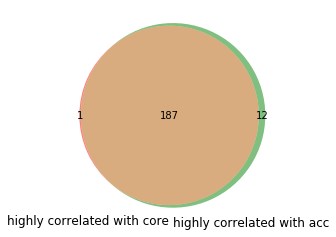

In [32]:
venn2([set(highly_core_Acc_genes_pao1), set(highly_acc_genes_pao1)],
      set_labels = ('highly correlated with core', 'highly correlated with acc'),
      set_colors=('red', 'green'),
      alpha=0.5
     )
plt.show()

**Observation:** Given the set of all accessory genes that are highly correlated with other accessory genes (correlation score > 0.5), all except 2 accessory genes are highly correlated in PAO1 samples and PA14 samples. There are two accessory gene that are only highly correlated in PA14 strains.

*Note:* For this analysis we are ignorning which gene pair has a high score and focused on if the gene is highly correlated to any accessory gene. This is why we have generated the dataframe to tell us more about who is connected to who.

## Examine expression of genes per group
**Question**
Is the reason for this shift because the accessory genes are absent? In other words, is the expression values for ALL accessory genes very low in across samples and so that is why they are all very correlated?

In [33]:
# Get mean, max, min expression per core gene
mean_real_core_expression = real_core_expression_pa14.mean()
max_real_core_expression = real_core_expression_pa14.max()
min_real_core_expression = real_core_expression_pa14.min()

In [34]:
# Get mean, max, min expression per accessory gene
mean_real_acc_expression = real_acc_expression_pa14.mean()
max_real_acc_expression = real_acc_expression_pa14.max()
min_real_acc_expression = real_acc_expression_pa14.min()

Text(0.5, 0, 'Mean gene expression')

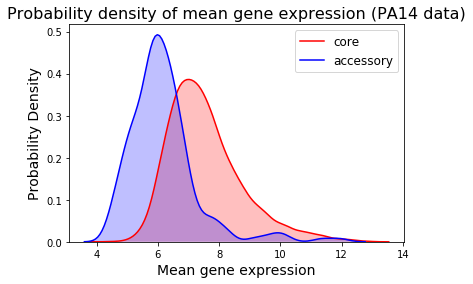

In [35]:
# Distribution plot for core genes
sns.distplot(mean_real_core_expression, 
             label='core', 
             color='red',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

sns.distplot(mean_real_acc_expression,
             label='accessory',
             color='blue',
             hist = False, 
             kde = True,
             kde_kws = {'shade': True}
            )

plt.legend(prop={'size': 12})
plt.title('Probability density of mean gene expression (PA14 data)',
         fontsize=16)
plt.ylabel('Probability Density', fontsize=14)
plt.xlabel('Mean gene expression', fontsize=14)

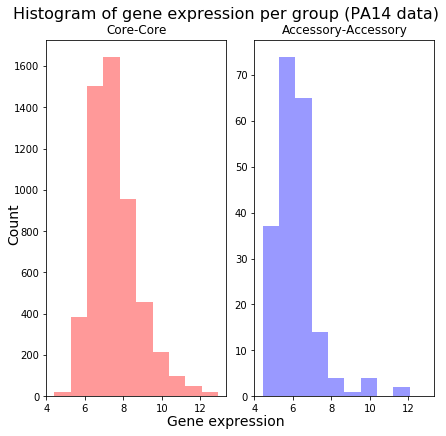

In [36]:
# Get bins using all data
hist, bins_expression = np.histogram(np.concatenate([mean_real_core_expression,
                                              mean_real_acc_expression]))


# Set up the matplotlib figure
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6,6))

# Distribution plot for core genes
sns.distplot(mean_real_core_expression, 
             label='core', 
             color='red',
             bins=bins_expression,
             kde=False,
             ax=axes[0]
            )

sns.distplot(mean_real_acc_expression,
             label='accessory',
             color='blue',
             bins=bins_expression,
             kde=False,
             ax=axes[1]
            )

plt.suptitle('Histogram of gene expression per group (PA14 data)',
            fontsize=16)
axes[0].set_title('Core-Core')
axes[1].set_title('Accessory-Accessory')
fig.text(0.5, 0.01, 'Gene expression', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Count', ha='center', rotation=90, fontsize=14)
plt.tight_layout(pad=0.4, 
                 w_pad=0.5,
                 h_pad=1.0,
                 rect=[0, 0.03, 1, 0.95])

**Take away**:
* If high corr(acc, acc) was due to gene absence, then I would’ve expected the average expression of accessory genes to be tightly spread near 0. But instead we see that average gene expression of accessory genes is similar to the core gene expression, even using only PA14 strains
* What can explain this? 